# Title
## Table of Contents

TODO

## Introduction

I picked this dataset so I could ask some basic questions about how AirBnb prices are related to other properties of the properties.

What general properties on an AirBnB location affect the price? e.g.:

- what neighbourhood is a listing in?
- number of bedrooms and bathrooms
- whole apartment/whole house
- is rating correlated to price

Sections 
- summary of the data
- data wrangling
- exploratory data analysis
- linear modelling

This project is part of the Data Science Nanodegree from Udacity.

### Description of the data

[Inside AirBNB](http://insideairbnb.com/get-the-data.html) provides 5 files (I've the filenames to avoid redundancy). A data dictionary is [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896).


- `listings_summary.csv` (was listings.csv)
    - condensed listings file
- `listings.csv` (was listings.csv.gz)
    - full listings data
- `reviews_summary.csv` (was reviews.csv)
    - dates of when reviews were.
- `reviews.csv` (was reviews.csv.gz)
    - full reviews data
- `calendar.csv`
    - availability calendar
    
Inspecting the data dict, I decided to use only `listings_summary.csv` and selected features from the `listings.csv`, as the `reviews.csv`, `calendar.csv`, and `reviews_summary.csv` are pretty well summarized and captured in the `listings.csv` anyways.


### Questions

## Wrangling

### Gather

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

plt.style.use('seaborn-darkgrid')
%matplotlib inline
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
# Map plotting
import geopandas as gpd
import contextily as ctx

In [3]:
# Use this is stitch together custom scale ticks
from itertools import chain

In [4]:
# Linear modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, auc, RocCurveDisplay

In [5]:
# Correlation metrics
from scipy.stats import spearmanr, pearsonr

In [6]:
# Read in data
listings_summary = pd.read_csv('data/listings_summary.csv')
listings = pd.read_csv('data/listings.csv')

### Assessing

#### `listings_summary`
This is what `listings_summary` looks like:

In [7]:
listings_summary.head()

id                                               name  host_id  \
0  10080                     D1 -  Million Dollar View 2 BR    30899   
1  13358  Monthly (or Longer ) Designer One Bedroom Down...    52116   
2  13490                       Vancouver's best kept secret    52467   
3  14267                                  EcoLoft Vancouver    56030   
4  16254        Close to PNE/Hastings Park and East Village    63238   

        host_name  neighbourhood_group             neighbourhood  latitude  \
0            Rami                  NaN                  Downtown  49.28872   
1            Lynn                  NaN                  West End  49.28201   
2            Iris                  NaN  Kensington-Cedar Cottage  49.25622   
3  Peter & Alison                  NaN  Kensington-Cedar Cottage  49.24922   
4           Jason                  NaN          Hastings-Sunrise  49.27721   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0 -123.12046  Entire home/apt    150              90                 16   
1 -123.12669  Entire home/apt     85              30                430   
2 -123.06607  Entire home/apt    145              30                 88   
3 -123.08139  Entire home/apt    140               3                 33   
4 -123.04086  Entire home/apt    195               3                  5   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2017-02-26               0.14                              40   
1  2021-01-01               3.27                               1   
2  2020-10-31               0.73                               1   
3  2020-02-07               0.26                               1   
4  2019-08-19               0.15                               1   

   availability_365  
0               346  
1                98  
2               203  
3               123  
4               289

In [8]:
listings_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4299 non-null   int64  
 1   name                            4299 non-null   object 
 2   host_id                         4299 non-null   int64  
 3   host_name                       4170 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   4299 non-null   object 
 6   latitude                        4299 non-null   float64
 7   longitude                       4299 non-null   float64
 8   room_type                       4299 non-null   object 
 9   price                           4299 non-null   int64  
 10  minimum_nights                  4299 non-null   int64  
 11  number_of_reviews               4299 non-null   int64  
 12  last_review                     34

`neighbourhood_group` is all NaN, so will be dropped.

I'm going to drop the `name` of the listing as well. Although there might be some correlation between the marketing value in a title, I don't plan on doing any text analysis.

`host_name` also will be dropped, as `host_id` will suffice for tracking hosts, if necessary.



In [9]:
listings_summary = listings_summary.drop(labels=['neighbourhood_group', 'name', 'host_name'], axis=1)

<br/>
<br/>




#### `listings`

I'm going to grab only useful looking features of out this data.

In [10]:
listings.head(1)

id                         listing_url       scrape_id last_scraped  \
0  10080  https://www.airbnb.com/rooms/10080  20210412154228   2021-04-13   

                             name  \
0  D1 -  Million Dollar View 2 BR   

                                         description neighborhood_overview  \
0  Stunning two bedroom, two bathroom apartment. ...                   NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/55778229/c2f7...    30899   

                                  host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/30899      Rami  2009-08-10   

                         host_location                    host_about  \
0  Vancouver, British Columbia, Canada  I will be happy to host you.   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour                93%                  87%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/55302...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/55302...       Coal Harbour   

   host_listings_count  host_total_listings_count  \
0                 49.0                       49.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   

  host_identity_verified neighbourhood neighbourhood_cleansed  \
0                      t           NaN               Downtown   

   neighbourhood_group_cleansed  latitude  longitude       property_type  \
0                           NaN  49.28872 -123.12046  Entire condominium   

         room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds  \
0  Entire home/apt             5        NaN        2 baths       2.0   2.0   

                                           amenities    price  minimum_nights  \
0  ["Iron", "Dryer", "Bed linens", "Cooking basic...  $150.00              90   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0            1124                      90                      90   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                    1124                    1124                    90.0   

   maximum_nights_avg_ntm  calendar_updated has_availability  availability_30  \
0                  1124.0               NaN                t               11   

   availability_60  availability_90  availability_365 calendar_last_scraped  \
0               41               71               346            2021-04-13   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                 16                      0                       0   

  first_review last_review  review_scores_rating  review_scores_accuracy  \
0   2011-11-15  2017-02-26                  93.0                     9.0   

   review_scores_cleanliness  review_scores_checkin  \
0                        9.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                          9.0                    10.0                  9.0   

     license instant_bookable  calculated_host_listings_count  \
0  18-476608                f                              40   

   calculated_host_listings_count_entire_homes  \
0                                           40   

   calculated_host_listings_count_private_rooms  \
0                                             0   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.14

In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4299 non-null   int64  
 1   listing_url                                   4299 non-null   object 
 2   scrape_id                                     4299 non-null   int64  
 3   last_scraped                                  4299 non-null   object 
 4   name                                          4299 non-null   object 
 5   description                                   4272 non-null   object 
 6   neighborhood_overview                         3074 non-null   object 
 7   picture_url                                   4299 non-null   object 
 8   host_id                                       4299 non-null   int64  
 9   host_url                                      4299 non-null   o

After a cursory inspection, a number of features related to the host, the properties of the room, and the reviews seem interesting.

In [12]:
interesting_props_dict = {'host': ['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
              'host_has_profile_pic', 'host_identity_verified'],
                          
                          'room': ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
               'amenities', 'instant_bookable'],
                          
                          'review': ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
               'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
                         }
                          

### Cleaning

I'll now look through the datasets we have and clean them as necessary, i.e. checking for duplicates, dealing with NaN's, and adjusting datatypes.

For clarity, I'll break the cleaning of `listings` into three parts related to different groups of features before combining them back together again with `listings_summary`.

In [13]:
## .copy() prevents SettingWithCopy warnings later on in the pipeline
# Features related to the host from listings.csv
listings_host = listings[interesting_props_dict['host']].copy()
# Features related to the room from listings.csv
listings_room = listings[interesting_props_dict['room']].copy()
# Features related to reviews from listings.csv
listings_review = listings[interesting_props_dict['review']].copy()

#### Helper functions for data cleaning
First, I'll define some helper functions for converting data types:

In [14]:
def convert_percent_to_float(string_percent):
    """
    Converts percentage strings to a float ratio e.g. 95% -> 0.95.
    
    For applying to dataframe elements. If element is NaN, returns back the element.
    """
    if pd.isna(string_percent):
        return string_percent
    else:
        return float(string_percent.strip('%'))/100

In [15]:
def convert_tf_to_float(string):
    """
    Converts strings of "t" and "f" to 1.0 or 0.0 floats.
    
    For applying to dataframe elements. If element is NaN, returns back the element.
    """ 
    if pd.isna(string):
        return string
    else:    
        return {'t':1, 'f':0}[string]

In [16]:
def convert_str_to_datetime(string, format='%Y-%m-%d'):
    """
    Converts strings of YYYY-MM-DD format (by default) to datetime objects.
    
    For applying to dataframe elements. If element is NaN, returns back the element.
    
    Uses pd.to_datetime.
    """ 
    return pd.to_datetime(string, format=format)
    

In [17]:
def col_apply_inplace(df, cols, f, **kwds):
    """
    Helper func to apply a func to elements of a column in-place.
    
    df   : input dataframe
    cols : single string or list of strings of column names
    f    : the function to apply to the elements of the columns
    kwds : keyword arguments to pass onto f
    """
    if type(cols) == str:
        df.loc[:,cols] = df.loc[:,cols].apply(f, **kwds)
    elif type(cols) == list:
        for col in cols:
            df.loc[:,col] = df.loc[:,col].apply(f, **kwds)
    else:
        raise ValueError('cols is not a single column name string or a list of column name strings')

#### Cleaning `listings_summary`

For `listings_summary`, `last_review` needs to be converted to datetimes.

In [18]:
listings_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4299 non-null   int64  
 1   host_id                         4299 non-null   int64  
 2   neighbourhood                   4299 non-null   object 
 3   latitude                        4299 non-null   float64
 4   longitude                       4299 non-null   float64
 5   room_type                       4299 non-null   object 
 6   price                           4299 non-null   int64  
 7   minimum_nights                  4299 non-null   int64  
 8   number_of_reviews               4299 non-null   int64  
 9   last_review                     3499 non-null   object 
 10  reviews_per_month               3499 non-null   float64
 11  calculated_host_listings_count  4299 non-null   int64  
 12  availability_365                42

In [19]:
# Convert to datetime
col_apply_inplace(listings_summary, 'last_review', convert_str_to_datetime)

#### Cleaning `listings_host`

`listings_host` is an all string dataframe 

In [20]:
listings_host.head()

host_since  host_response_time host_response_rate host_acceptance_rate  \
0  2009-08-10      within an hour                93%                  87%   
1  2009-11-07        within a day               100%                  57%   
2  2009-11-08      within an hour               100%                  78%   
3  2009-11-20  within a few hours               100%                  NaN   
4  2009-12-15                 NaN                NaN                  NaN   

  host_is_superhost host_has_profile_pic host_identity_verified  
0                 f                    t                      t  
1                 t                    f                      t  
2                 t                    t                      t  
3                 f                    t                      t  
4                 f                    t                      t

In [21]:
listings_host.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_since              4170 non-null   object
 1   host_response_time      2991 non-null   object
 2   host_response_rate      2991 non-null   object
 3   host_acceptance_rate    3099 non-null   object
 4   host_is_superhost       4170 non-null   object
 5   host_has_profile_pic    4170 non-null   object
 6   host_identity_verified  4170 non-null   object
dtypes: object(7)
memory usage: 235.2+ KB


I'll need to convert t/f columns to 1.0 and 0.0 representing true and false, convert dates to datetimes, and percentages to ratios.

In [22]:
col_apply_inplace(listings_host, 'host_since', convert_str_to_datetime)

col_apply_inplace(listings_host, 
                  ['host_response_rate', 'host_acceptance_rate'], 
                  convert_percent_to_float)

col_apply_inplace(listings_host, 
                  ['host_is_superhost','host_has_profile_pic','host_identity_verified'], 
                  convert_tf_to_float)

In [23]:
listings_host.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   host_since              4170 non-null   datetime64[ns]
 1   host_response_time      2991 non-null   object        
 2   host_response_rate      2991 non-null   float64       
 3   host_acceptance_rate    3099 non-null   float64       
 4   host_is_superhost       4170 non-null   float64       
 5   host_has_profile_pic    4170 non-null   float64       
 6   host_identity_verified  4170 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 235.2+ KB


In [24]:
listings_host.head()

host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0 2009-08-10      within an hour                0.93                  0.87   
1 2009-11-07        within a day                1.00                  0.57   
2 2009-11-08      within an hour                1.00                  0.78   
3 2009-11-20  within a few hours                1.00                   NaN   
4 2009-12-15                 NaN                 NaN                   NaN   

   host_is_superhost  host_has_profile_pic  host_identity_verified  
0                0.0                   1.0                     1.0  
1                1.0                   0.0                     1.0  
2                1.0                   1.0                     1.0  
3                0.0                   1.0                     1.0  
4                0.0                   1.0                     1.0

#### Cleaning `listings_room`

`listings_room` has two columns of note. `bathrooms_text` are host-entered strings describing their bathroom situation, whereas `amenities` is are json formatted collections of various amenities the property has.

In [25]:
listings_room.head()

property_type        room_type  accommodates  bathrooms  \
0  Entire condominium  Entire home/apt             5        NaN   
1  Entire condominium  Entire home/apt             2        NaN   
2    Entire apartment  Entire home/apt             2        NaN   
3        Entire house  Entire home/apt             4        NaN   
4  Entire guest suite  Entire home/apt             4        NaN   

  bathrooms_text  bedrooms  beds  \
0        2 baths       2.0   2.0   
1         1 bath       1.0   1.0   
2         1 bath       1.0   1.0   
3         1 bath       1.0   2.0   
4         1 bath       2.0   3.0   

                                           amenities instant_bookable  
0  ["Iron", "Dryer", "Bed linens", "Cooking basic...                f  
1  ["Iron", "Dryer", "Bed linens", "Cooking basic...                f  
2  ["Iron", "Outdoor dining area", "Ethernet conn...                f  
3  ["Iron", "Dryer", "Cooking basics", "Hot water...                t  
4  ["Iron", "Dryer", "Bed linens", "Cooking basic...                t

In [26]:
listings_room.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_type     4299 non-null   object 
 1   room_type         4299 non-null   object 
 2   accommodates      4299 non-null   int64  
 3   bathrooms         0 non-null      float64
 4   bathrooms_text    4297 non-null   object 
 5   bedrooms          3987 non-null   float64
 6   beds              4263 non-null   float64
 7   amenities         4299 non-null   object 
 8   instant_bookable  4299 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 302.4+ KB


Inspecting the amenities, each property has a combination of many amenities. These aren't very standardized.

In [27]:
amen = listings_room['amenities'].copy()

In [28]:
amen.value_counts()

["Heating", "Kitchen", "Stove", "Microwave", "Dryer", "Washer", "Wifi", "Long term stays allowed", "TV", "Hot water", "Smoke alarm", "Oven"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Pulling out the individual amenities, it's a long-tailed distribution (i.e. most amenity types are present in low-count, but there are a lot of them).

In [29]:
amenity_series = pd.Series([item for sublist in amen for item in json.loads(sublist)]).value_counts()

In [30]:
amenity_series

Wifi                                                                                                                                                                4226
Heating                                                                                                                                                             4138
Smoke alarm                                                                                                                                                         4112
Essentials                                                                                                                                                          4001
Kitchen                                                                                                                                                             3986
Long term stays allowed                                                                                                                                    

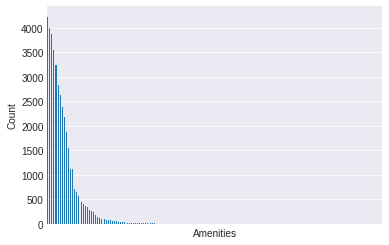

In [35]:
ax =  amenity_series.plot(kind='bar')
#ax = plt.bar(amenity_series.index, amenity_series.values, color='red')
#axes = sns.barplot(x=amenity_series.index, y=amenity_series.values) 
# Turn off x-axis, otherwise x tick labels are a mess
ax.set_xticks([])
ax.set_xlabel('Amenities')
ax.set_ylabel('Count');

One way to deal with this would be to pull out only the most popular amenities.

In [37]:
amenity_series.describe()

count     495.000000
mean      243.573737
std       760.174209
min         1.000000
25%         1.000000
50%         1.000000
75%        18.500000
max      4226.000000
dtype: float64

In [38]:
amenity_series.index[amenity_series >= 20].size

123

In [39]:
amenity_series.index[amenity_series >= 1000].size

38

An arbitrary threshold of having at least a count of 1000 might be reasonable

In [40]:
amenities_to_keep = amenity_series.index[amenity_series >= 1000]
# Make an zeros df
amenities_df = pd.DataFrame(np.zeros([listings_room.shape[0], amenities_to_keep.size]), columns=amenities_to_keep)

# Fill in the df by for loop, 1/0, basically dummy columns.
# Seems pretty slow.
for i, item in enumerate(listings_room['amenities']):
    amenities = json.loads(item)
    for amenity in amenities:
        amenities_df.iloc[i,:].loc[amenity] = 1

In [41]:
# Checking to see if correctly populated, by comparing to next cell
amenities_df.head()

Wifi  Heating  Smoke alarm  Essentials  Kitchen  Long term stays allowed  \
0   1.0      1.0          1.0         0.0      1.0                      1.0   
1   1.0      1.0          1.0         1.0      1.0                      1.0   
2   1.0      0.0          1.0         1.0      1.0                      1.0   
3   1.0      1.0          1.0         1.0      1.0                      1.0   
4   1.0      0.0          1.0         1.0      1.0                      1.0   

   Hangers  Washer  Dryer  Hair dryer  Hot water  Iron  Shampoo  \
0      1.0     1.0    1.0         1.0        1.0   1.0      0.0   
1      1.0     1.0    1.0         1.0        1.0   1.0      1.0   
2      1.0     0.0    1.0         1.0        1.0   1.0      1.0   
3      1.0     1.0    1.0         1.0        1.0   1.0      1.0   
4      1.0     1.0    1.0         1.0        1.0   1.0      1.0   

   Dedicated workspace   TV  Carbon monoxide alarm  Dishes and silverware  \
0                  1.0  0.0                    1.0                    1.0   
1                  1.0  0.0                    1.0                    1.0   
2                  0.0  0.0                    1.0                    1.0   
3                  1.0  1.0                    0.0                    1.0   
4                  1.0  0.0                    1.0                    1.0   

   Fire extinguisher  Refrigerator  Cooking basics  Microwave  Coffee maker  \
0                0.0           1.0             1.0        1.0           1.0   
1                0.0           1.0             1.0        1.0           1.0   
2                1.0           1.0             1.0        1.0           1.0   
3                1.0           1.0             1.0        1.0           1.0   
4                1.0           1.0             1.0        1.0           1.0   

   Stove  Oven  Free parking on premises  Private entrance  Bed linens  \
0    1.0   0.0                       1.0               0.0         1.0   
1    1.0   1.0                       0.0               0.0         1.0   
2    1.0   1.0                       1.0               1.0         1.0   
3    1.0   1.0                       0.0               0.0         0.0   
4    1.0   1.0                       1.0               1.0         1.0   

   Free street parking  Dishwasher  First aid kit  Patio or balcony  \
0                  0.0         1.0            0.0               0.0   
1                  0.0         1.0            0.0               0.0   
2                  1.0         1.0            0.0               1.0   
3                  1.0         1.0            0.0               0.0   
4                  1.0         0.0            0.0               1.0   

   Extra pillows and blankets  Elevator  Cable TV  Luggage dropoff allowed  \
0                         0.0       1.0       1.0                      0.0   
1                         1.0       1.0       1.0                      0.0   
2                         0.0       0.0       1.0                      1.0   
3                         0.0       0.0       0.0                      0.0   
4                         1.0       0.0       0.0                      1.0   

   Air conditioning  Gym  Backyard  
0               1.0  1.0       0.0  
1               1.0  1.0       0.0  
2               0.0  1.0       0.0  
3               0.0  0.0       0.0  
4               0.0  0.0       0.0

In [42]:
listings_room.iloc[0,:]['amenities']

'["Iron", "Dryer", "Bed linens", "Cooking basics", "Elevator", "Hot water", "Indoor fireplace", "Dishes and silverware", "Stove", "Microwave", "Long term stays allowed", "TV with standard cable", "Refrigerator", "Hangers", "Pool", "Air conditioning", "Hair dryer", "Cable TV", "Gym", "Washer", "Wifi", "Carbon monoxide alarm", "Dedicated workspace", "Free parking on premises", "Smoke alarm", "Heating", "Kitchen", "Coffee maker", "Dishwasher", "Host greets you"]'

I'll prefix the columns in `amenities_df`, then drop the `amenities` column in `listings_room`, before glueing `amenities_df` back on:

In [43]:
amenities_df.columns = 'amenity_' + amenities_df.columns.str.lower()
listings_room = listings_room.drop(labels=['amenities'], axis=1)
listings_room = pd.concat([listings_room, amenities_df], axis=1)

In [44]:
listings_room.head()

property_type        room_type  accommodates  bathrooms  \
0  Entire condominium  Entire home/apt             5        NaN   
1  Entire condominium  Entire home/apt             2        NaN   
2    Entire apartment  Entire home/apt             2        NaN   
3        Entire house  Entire home/apt             4        NaN   
4  Entire guest suite  Entire home/apt             4        NaN   

  bathrooms_text  bedrooms  beds instant_bookable  amenity_wifi  \
0        2 baths       2.0   2.0                f           1.0   
1         1 bath       1.0   1.0                f           1.0   
2         1 bath       1.0   1.0                f           1.0   
3         1 bath       1.0   2.0                t           1.0   
4         1 bath       2.0   3.0                t           1.0   

   amenity_heating  amenity_smoke alarm  amenity_essentials  amenity_kitchen  \
0              1.0                  1.0                 0.0              1.0   
1              1.0                  1.0                 1.0              1.0   
2              0.0                  1.0                 1.0              1.0   
3              1.0                  1.0                 1.0              1.0   
4              0.0                  1.0                 1.0              1.0   

   amenity_long term stays allowed  amenity_hangers  amenity_washer  \
0                              1.0              1.0             1.0   
1                              1.0              1.0             1.0   
2                              1.0              1.0             0.0   
3                              1.0              1.0             1.0   
4                              1.0              1.0             1.0   

   amenity_dryer  amenity_hair dryer  amenity_hot water  amenity_iron  \
0            1.0                 1.0                1.0           1.0   
1            1.0                 1.0                1.0           1.0   
2            1.0                 1.0                1.0           1.0   
3            1.0                 1.0                1.0           1.0   
4            1.0                 1.0                1.0           1.0   

   amenity_shampoo  amenity_dedicated workspace  amenity_tv  \
0              0.0                          1.0         0.0   
1              1.0                          1.0         0.0   
2              1.0                          0.0         0.0   
3              1.0                          1.0         1.0   
4              1.0                          1.0         0.0   

   amenity_carbon monoxide alarm  amenity_dishes and silverware  \
0                            1.0                            1.0   
1                            1.0                            1.0   
2                            1.0                            1.0   
3                            0.0                            1.0   
4                            1.0                            1.0   

   amenity_fire extinguisher  amenity_refrigerator  amenity_cooking basics  \
0                        0.0                   1.0                     1.0   
1                        0.0                   1.0                     1.0   
2                        1.0                   1.0                     1.0   
3                        1.0                   1.0                     1.0   
4                        1.0                   1.0                     1.0   

   amenity_microwave  amenity_coffee maker  amenity_stove  amenity_oven  \
0                1.0                   1.0            1.0           0.0   
1                1.0                   1.0            1.0           1.0   
2                1.0                   1.0            1.0           1.0   
3                1.0                   1.0            1.0           1.0   
4                1.0                   1.0            1.0           1.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   
1                      

Next, I'll extract numeric values from the bathroom text.

In [45]:
listings_room['bathrooms_text'].value_counts()

1 bath               2442
2 baths               610
1 shared bath         409
1 private bath        290
1.5 baths             185
2.5 baths             102
2 shared baths         62
3 baths                51
1.5 shared baths       44
3.5 baths              29
4 baths                17
3 shared baths          9
0 shared baths          9
0 baths                 8
6 baths                 5
4 shared baths          5
Shared half-bath        4
5 baths                 4
4.5 baths               3
Private half-bath       2
7 baths                 2
5.5 baths               2
Half-bath               1
6.5 baths               1
3.5 shared baths        1
Name: bathrooms_text, dtype: int64

All the values have a numeric value in the front, unless they are half-baths. I'll code half-baths as 0.5 bathrooms. I'll ignore the "shared" or "private" status, as it does not seem to be totally correlated with the type of property. 

In [46]:
def convert_bathrooms(txt):
    """
    Convert bathroom description string to a float.
    
    If the txt begins with a number, grabs the number by splitting on whitespace and returns it.
    
    Otherwise, it's a half bath, so return 0.5.
    
    Returns NaN if NaN encountered.
    """
    if pd.isna(txt):
        return np.nan
    elif txt[0].isnumeric():
        return float(txt.split(" ")[0])
    else:
        return 0.5  

In [47]:
# Testing the bathroom text conversion
listings_room['bathrooms_text'].apply(convert_bathrooms).value_counts()

1.0    3141
2.0     672
1.5     229
2.5     102
3.0      60
3.5      30
4.0      22
0.0      17
0.5       7
6.0       5
5.0       4
4.5       3
5.5       2
7.0       2
6.5       1
Name: bathrooms_text, dtype: int64

In [48]:
col_apply_inplace(listings_room, ['bathrooms_text'], convert_bathrooms)

`bathrooms` is all NaN, so I'll just drop it

In [49]:
listings_room['bathrooms'].isna().mean()

1.0

In [50]:
listings_room.drop(labels=['bathrooms'], axis=1, inplace=True)

In [51]:
listings_room.head()

property_type        room_type  accommodates  bathrooms_text  \
0  Entire condominium  Entire home/apt             5             2.0   
1  Entire condominium  Entire home/apt             2             1.0   
2    Entire apartment  Entire home/apt             2             1.0   
3        Entire house  Entire home/apt             4             1.0   
4  Entire guest suite  Entire home/apt             4             1.0   

   bedrooms  beds instant_bookable  amenity_wifi  amenity_heating  \
0       2.0   2.0                f           1.0              1.0   
1       1.0   1.0                f           1.0              1.0   
2       1.0   1.0                f           1.0              0.0   
3       1.0   2.0                t           1.0              1.0   
4       2.0   3.0                t           1.0              0.0   

   amenity_smoke alarm  amenity_essentials  amenity_kitchen  \
0                  1.0                 0.0              1.0   
1                  1.0                 1.0              1.0   
2                  1.0                 1.0              1.0   
3                  1.0                 1.0              1.0   
4                  1.0                 1.0              1.0   

   amenity_long term stays allowed  amenity_hangers  amenity_washer  \
0                              1.0              1.0             1.0   
1                              1.0              1.0             1.0   
2                              1.0              1.0             0.0   
3                              1.0              1.0             1.0   
4                              1.0              1.0             1.0   

   amenity_dryer  amenity_hair dryer  amenity_hot water  amenity_iron  \
0            1.0                 1.0                1.0           1.0   
1            1.0                 1.0                1.0           1.0   
2            1.0                 1.0                1.0           1.0   
3            1.0                 1.0                1.0           1.0   
4            1.0                 1.0                1.0           1.0   

   amenity_shampoo  amenity_dedicated workspace  amenity_tv  \
0              0.0                          1.0         0.0   
1              1.0                          1.0         0.0   
2              1.0                          0.0         0.0   
3              1.0                          1.0         1.0   
4              1.0                          1.0         0.0   

   amenity_carbon monoxide alarm  amenity_dishes and silverware  \
0                            1.0                            1.0   
1                            1.0                            1.0   
2                            1.0                            1.0   
3                            0.0                            1.0   
4                            1.0                            1.0   

   amenity_fire extinguisher  amenity_refrigerator  amenity_cooking basics  \
0                        0.0                   1.0                     1.0   
1                        0.0                   1.0                     1.0   
2                        1.0                   1.0                     1.0   
3                        1.0                   1.0                     1.0   
4                        1.0                   1.0                     1.0   

   amenity_microwave  amenity_coffee maker  amenity_stove  amenity_oven  \
0                1.0                   1.0            1.0           0.0   
1                1.0                   1.0            1.0           1.0   
2                1.0                   1.0            1.0           1.0   
3                1.0                   1.0            1.0           1.0   
4                1.0                   1.0            1.0           1.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   
1                               0.0                       0.0   
2                 

`property_type` and `room_type` seem to encode similar information, except `property_type` is much more diverse.

In [52]:
listings_room['property_type'].value_counts()

Entire apartment                      1012
Entire condominium                     816
Entire house                           642
Private room in house                  561
Entire guest suite                     513
Private room in apartment              155
Entire loft                            112
Entire townhouse                        91
Entire serviced apartment               69
Private room in condominium             63
Entire guesthouse                       50
Private room in townhouse               34
Private room in villa                   26
Private room in guest suite             21
Room in boutique hotel                  19
Entire bungalow                         14
Private room in bed and breakfast       10
Shared room in house                     9
Entire place                             8
Private room in guesthouse               7
Room in aparthotel                       7
Shared room in apartment                 7
Room in hotel                            6
Entire vill

In [53]:
listings_room['room_type'].value_counts()

Entire home/apt    3359
Private room        915
Shared room          21
Hotel room            4
Name: room_type, dtype: int64

Rather than deal with `property_type`, I'll just drop it

In [54]:
listings_room = listings_room.drop(labels=['property_type'], axis=1)

`instant_bookable` is t/f representing true/false, so I'll convert that to 1/0's

In [55]:
col_apply_inplace(listings_room, 
                  ['instant_bookable'], 
                  convert_tf_to_float)

#### Cleanign `listings_review`

In [56]:
listings_review.head()

number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                 16                      0                       0   
1                430                      3                       0   
2                 88                      4                       0   
3                 33                      0                       0   
4                  5                      0                       0   

  first_review  review_scores_rating  review_scores_accuracy  \
0   2011-11-15                  93.0                     9.0   
1   2010-06-22                  93.0                     9.0   
2   2011-06-02                  98.0                    10.0   
3   2010-10-03                  95.0                    10.0   
4   2018-08-04                  96.0                    10.0   

   review_scores_cleanliness  review_scores_checkin  \
0                        9.0                   10.0   
1                       10.0                    9.0   
2                       10.0                   10.0   
3                        9.0                   10.0   
4                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  
0                          9.0                    10.0                  9.0  
1                         10.0                    10.0                  9.0  
2                         10.0                    10.0                 10.0  
3                          9.0                    10.0                  9.0  
4                         10.0                    10.0                  9.0

In [57]:
listings_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   number_of_reviews            4299 non-null   int64  
 1   number_of_reviews_ltm        4299 non-null   int64  
 2   number_of_reviews_l30d       4299 non-null   int64  
 3   first_review                 3499 non-null   object 
 4   review_scores_rating         3474 non-null   float64
 5   review_scores_accuracy       3462 non-null   float64
 6   review_scores_cleanliness    3462 non-null   float64
 7   review_scores_checkin        3461 non-null   float64
 8   review_scores_communication  3463 non-null   float64
 9   review_scores_location       3462 non-null   float64
 10  review_scores_value          3462 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 369.6+ KB


The only thing I'll change here is converting dates to datetime format

In [58]:
col_apply_inplace(listings_review, ['first_review'], convert_str_to_datetime)

In [59]:
listings_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   number_of_reviews            4299 non-null   int64         
 1   number_of_reviews_ltm        4299 non-null   int64         
 2   number_of_reviews_l30d       4299 non-null   int64         
 3   first_review                 3499 non-null   datetime64[ns]
 4   review_scores_rating         3474 non-null   float64       
 5   review_scores_accuracy       3462 non-null   float64       
 6   review_scores_cleanliness    3462 non-null   float64       
 7   review_scores_checkin        3461 non-null   float64       
 8   review_scores_communication  3463 non-null   float64       
 9   review_scores_location       3462 non-null   float64       
 10  review_scores_value          3462 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)


#### Putting the dataframe back together

Let's put the cleaned data back into one dataframe.

In [60]:
df = pd.concat([listings_summary, listings_host, listings_room, listings_review], axis=1)

In [61]:
df.head()

id  host_id             neighbourhood  latitude  longitude  \
0  10080    30899                  Downtown  49.28872 -123.12046   
1  13358    52116                  West End  49.28201 -123.12669   
2  13490    52467  Kensington-Cedar Cottage  49.25622 -123.06607   
3  14267    56030  Kensington-Cedar Cottage  49.24922 -123.08139   
4  16254    63238          Hastings-Sunrise  49.27721 -123.04086   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    150              90                 16  2017-02-26   
1  Entire home/apt     85              30                430  2021-01-01   
2  Entire home/apt    145              30                 88  2020-10-31   
3  Entire home/apt    140               3                 33  2020-02-07   
4  Entire home/apt    195               3                  5  2019-08-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.14                              40               346   
1               3.27                               1                98   
2               0.73                               1               203   
3               0.26                               1               123   
4               0.15                               1               289   

  host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0 2009-08-10      within an hour                0.93                  0.87   
1 2009-11-07        within a day                1.00                  0.57   
2 2009-11-08      within an hour                1.00                  0.78   
3 2009-11-20  within a few hours                1.00                   NaN   
4 2009-12-15                 NaN                 NaN                   NaN   

   host_is_superhost  host_has_profile_pic  host_identity_verified  \
0                0.0                   1.0                     1.0   
1                1.0                   0.0                     1.0   
2                1.0                   1.0                     1.0   
3                0.0                   1.0                     1.0   
4                0.0                   1.0                     1.0   

         room_type  accommodates  bathrooms_text  bedrooms  beds  \
0  Entire home/apt             5             2.0       2.0   2.0   
1  Entire home/apt             2             1.0       1.0   1.0   
2  Entire home/apt             2             1.0       1.0   1.0   
3  Entire home/apt             4             1.0       1.0   2.0   
4  Entire home/apt             4             1.0       2.0   3.0   

   instant_bookable  amenity_wifi  amenity_heating  amenity_smoke alarm  \
0                 0           1.0              1.0                  1.0   
1                 0           1.0              1.0                  1.0   
2                 0           1.0              0.0                  1.0   
3                 1           1.0              1.0                  1.0   
4                 1           1.0              0.0                  1.0   

   amenity_essentials  amenity_kitchen  amenity_long term stays allowed  \
0                 0.0              1.0                              1.0   
1                 1.0              1.0                              1.0   
2                 1.0              1.0                              1.0   
3                 1.0              1.0                              1.0   
4                 1.0              1.0                              1.0   

   amenity_hangers  amenity_washer  amenity_dryer  amenity_hair dryer  \
0              1.0             1.0            1.0                 1.0   
1              1.0             1.0            1.0                 1.0   
2              1.0             0.0            1.0                 1.0   
3              1.0             1.0            1.0                 1.0   
4              1.0             1.0            1.0                 1.0   

   amenity_hot water  amenity_iron  amenity_shampoo  \


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  4299 non-null   int64         
 1   host_id                             4299 non-null   int64         
 2   neighbourhood                       4299 non-null   object        
 3   latitude                            4299 non-null   float64       
 4   longitude                           4299 non-null   float64       
 5   room_type                           4299 non-null   object        
 6   price                               4299 non-null   int64         
 7   minimum_nights                      4299 non-null   int64         
 8   number_of_reviews                   4299 non-null   int64         
 9   last_review                         3499 non-null   datetime64[ns]
 10  reviews_per_month       

Check for duplicated rows:

In [63]:
df.duplicated().sum()

0

There are two duplicated columns:

In [64]:
df.columns[df.columns.duplicated()]

Index(['room_type', 'number_of_reviews'], dtype='object')

Drop the duplicated columns:

In [65]:
df = df.loc[:, ~df.columns.duplicated()]

Rearrange the columns to put some properties from `listings_summary` next to other grouped properties

In [66]:
df.columns

Index(['id', 'host_id', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'instant_bookable',
       'amenity_wifi', 'amenity_heating', 'amenity_smoke alarm',
       'amenity_essentials', 'amenity_kitchen',
       'amenity_long term stays allowed', 'amenity_hangers', 'amenity_washer',
       'amenity_dryer', 'amenity_hair dryer', 'amenity_hot water',
       'amenity_iron', 'amenity_shampoo', 'amenity_dedicated workspace',
       'amenity_tv', 'amenity_carbon monoxide alarm',
       'amenity_dishes and silverware', 'amenity_fire extinguisher',
       'amenity_refrigerator', 'amenity_cooking basics', 'a

In [67]:
df = df[['id',  'neighbourhood', 'latitude', 'longitude',
       'price', 'minimum_nights',
       'availability_365', 
       # Host properties
       'host_id',
       'calculated_host_listings_count',
       'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       # Room properties
       'accommodates',
       'room_type',
       'bathrooms_text', 'bedrooms', 'beds', 'instant_bookable',
       'amenity_wifi', 'amenity_heating', 'amenity_smoke alarm',
       'amenity_essentials', 'amenity_kitchen',
       'amenity_long term stays allowed', 'amenity_hangers', 'amenity_washer',
       'amenity_dryer', 'amenity_hair dryer', 'amenity_hot water',
       'amenity_iron', 'amenity_shampoo', 'amenity_dedicated workspace',
       'amenity_tv', 'amenity_carbon monoxide alarm',
       'amenity_dishes and silverware', 'amenity_fire extinguisher',
       'amenity_refrigerator', 'amenity_cooking basics', 'amenity_microwave',
       'amenity_coffee maker', 'amenity_stove', 'amenity_oven',
       'amenity_free parking on premises', 'amenity_private entrance',
       'amenity_bed linens', 'amenity_free street parking',
       'amenity_dishwasher', 'amenity_first aid kit',
       'amenity_patio or balcony', 'amenity_extra pillows and blankets',
       'amenity_elevator', 'amenity_cable tv',
       'amenity_luggage dropoff allowed', 'amenity_air conditioning',
       'amenity_gym', 'amenity_backyard', 
       # Review properties
       'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review', 
       'reviews_per_month', 
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']]

In [68]:
df.head(1)

id neighbourhood  latitude  longitude  price  minimum_nights  \
0  10080      Downtown  49.28872 -123.12046    150              90   

   availability_365  host_id  calculated_host_listings_count host_since  \
0               346    30899                              40 2009-08-10   

  host_response_time  host_response_rate  host_acceptance_rate  \
0     within an hour                0.93                  0.87   

   host_is_superhost  host_has_profile_pic  host_identity_verified  \
0                0.0                   1.0                     1.0   

   accommodates        room_type  bathrooms_text  bedrooms  beds  \
0             5  Entire home/apt             2.0       2.0   2.0   

   instant_bookable  amenity_wifi  amenity_heating  amenity_smoke alarm  \
0                 0           1.0              1.0                  1.0   

   amenity_essentials  amenity_kitchen  amenity_long term stays allowed  \
0                 0.0              1.0                              1.0   

   amenity_hangers  amenity_washer  amenity_dryer  amenity_hair dryer  \
0              1.0             1.0            1.0                 1.0   

   amenity_hot water  amenity_iron  amenity_shampoo  \
0                1.0           1.0              0.0   

   amenity_dedicated workspace  amenity_tv  amenity_carbon monoxide alarm  \
0                          1.0         0.0                            1.0   

   amenity_dishes and silverware  amenity_fire extinguisher  \
0                            1.0                        0.0   

   amenity_refrigerator  amenity_cooking basics  amenity_microwave  \
0                   1.0                     1.0                1.0   

   amenity_coffee maker  amenity_stove  amenity_oven  \
0                   1.0            1.0           0.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   

   amenity_bed linens  amenity_free street parking  amenity_dishwasher  \
0                 1.0                          0.0                 1.0   

   amenity_first aid kit  amenity_patio or balcony  \
0                    0.0                       0.0   

   amenity_extra pillows and blankets  amenity_elevator  amenity_cable tv  \
0                                 0.0               1.0               1.0   

   amenity_luggage dropoff allowed  amenity_air conditioning  amenity_gym  \
0                              0.0                       1.0          1.0   

   amenity_backyard  number_of_reviews  number_of_reviews_ltm  \
0               0.0                 16                      0   

   number_of_reviews_l30d first_review last_review  reviews_per_month  \
0                       0   2011-11-15  2017-02-26               0.14   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  93.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                          9.0                    10.0   

   review_scores_value  
0                  9.0

## Exploratory Data Analysis
WHAT is price? Probably not including custom pricing for nights/weeks/months, and not smart pricing (surge pricing). Not sure if cleaning/service fees are amalgamated. Probably just nightly, not sure how dates are adjusted. Rough estimator.

TODO: downtown east side pricing??

- what neighbourhood is a listing in?
- number of bedrooms and bathrooms
- whole apartment/whole house
- is rating correlated to price

### Q1: What neighbourhoods are the listings in?

To answer this, I'll use [GeoPandas](https://geopandas.org/) to plot locations onto a map of Vancouver.

First, I'll gather the coordinates of the neighbourhoods, and the latitudes/longitudes of the locations

In [71]:
# Make points out of latitude and longitude
# Use EPSG:4326 coordinates as a default
locations = gpd.GeoDataFrame(df[['latitude', 'longitude']], geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='EPSG:4326')
locations.head(1)

latitude  longitude                     geometry
0  49.28872 -123.12046  POINT (-123.12046 49.28872)

In [72]:
# Delineates the locations of each neighbourhood
neighbourhoods = gpd.read_file('data/neighbourhoods.geojson')
# Drop neighbourhood group as it is empty
neighbourhoods.drop(labels='neighbourhood_group', axis=1, inplace=True)
neighbourhoods.head()

neighbourhood                                           geometry
0    Dunbar Southlands  MULTIPOLYGON (((-123.17909 49.21708, -123.1791...
1  Renfrew-Collingwood  MULTIPOLYGON (((-123.05888 49.23286, -123.0588...
2     Hastings-Sunrise  MULTIPOLYGON (((-123.05660 49.26215, -123.0566...
3             Oakridge  MULTIPOLYGON (((-123.14015 49.21935, -123.1401...
4    Downtown Eastside  MULTIPOLYGON (((-123.09988 49.27604, -123.1022...

In [73]:
# Check the coordinate reference system
neighbourhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

A [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system) is a set of rules that converts locations to a set of points that can be plotted. [EPSG:4326](https://epsg.io/4326) is a common default, but because I want to use `contextily` to grab a background map for the plot, I'll need to convert to another coordinate system [EPSG:3857](https://epsg.io/3857) to the `contextily` maps.


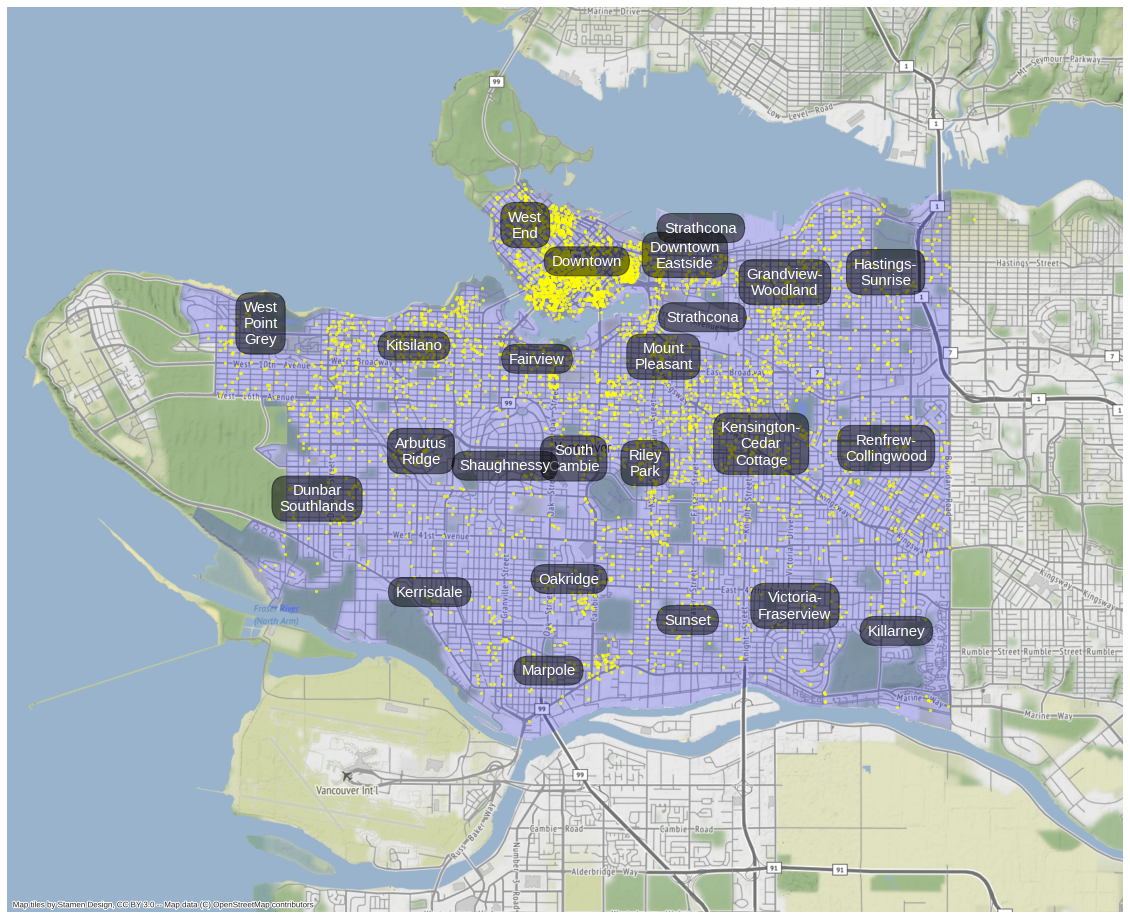

In [74]:
p_mercator = 'EPSG:3857' # Pseudo-Mercator projection, as this is what map services background is in


ax = neighbourhoods.to_crs(p_mercator).plot(figsize=(20,20), color='#0000FF33', linewidth=2.5)
locations.to_crs(p_mercator).plot(color='yellow', markersize=5, ax=ax,alpha=0.7)

lims = np.array(neighbourhoods.to_crs(p_mercator).total_bounds) # xmin, ymin, xmax, ymax
margin = 5000
lims = lims + np.array([-margin, -margin, margin, margin])
ax.set_xlim(lims[0], lims[2])
ax.set_ylim(lims[1], lims[3])
# Grab the BG tile
ctx.add_basemap(ax)
# Turn off seaborn theme lines and axes
plt.axis('off');

# Add neighbourhood names:
# See https://stackoverflow.com/questions/38899190/geopandas-label-polygons
# 1) Get points within each neighbourhood (tuples of xy's)
label_coords = neighbourhoods['geometry'].to_crs(p_mercator).apply(lambda x: x.centroid.coords[0])
# 2) Plot them
for i, nbh in neighbourhoods['neighbourhood'].iteritems():
   # Add \n for better text placement
   nbh = nbh.replace(' ', '\n').replace('-', '-\n')
   plt.text(x=label_coords.iloc[i][0], y=label_coords.iloc[i][1] , s=nbh,
            horizontalalignment='center', color='white', size=15,
            bbox=dict(facecolor='black', alpha=0.5, boxstyle="Round, pad=0.5, rounding_size=1"))
    

Looks like Downtown is a hotspot of listings, let's confirm:

In [77]:
df['neighbourhood'].value_counts()

Downtown                    1153
Kitsilano                    348
West End                     347
Kensington-Cedar Cottage     278
Mount Pleasant               246
Downtown Eastside            232
Riley Park                   227
Grandview-Woodland           199
Renfrew-Collingwood          159
Hastings-Sunrise             151
Fairview                     132
Dunbar Southlands            128
Marpole                      103
Sunset                        88
West Point Grey               75
Oakridge                      74
Shaughnessy                   69
Arbutus Ridge                 64
South Cambie                  58
Killarney                     55
Victoria-Fraserview           54
Kerrisdale                    42
Strathcona                    17
Name: neighbourhood, dtype: int64

### Q2: What is the distribution of the prices of the listings?
Prices in this dataset are whatever was scraped off the AirBNB website. It does not account for complexities such as surge pricing or fine-grained host adjustments by date.

Here is the overall distribution of prices. The prices are right-skewed, with some a smattering of very expensive listings, while the median is 115 CAD per night.

In [87]:
df.query('price == 3250')

id neighbourhood  latitude  longitude  price  minimum_nights  \
2713  37181228      Downtown  49.27886 -123.12598   3250             180   

      availability_365    host_id  calculated_host_listings_count host_since  \
2713               363  262528648                               1 2019-05-18   

     host_response_time  host_response_rate  host_acceptance_rate  \
2713                NaN                 NaN                   NaN   

      host_is_superhost  host_has_profile_pic  host_identity_verified  \
2713                0.0                   1.0                     0.0   

      accommodates        room_type  bathrooms_text  bedrooms  beds  \
2713             2  Entire home/apt             1.0       1.0   1.0   

      instant_bookable  amenity_wifi  amenity_heating  amenity_smoke alarm  \
2713                 1           1.0              1.0                  1.0   

      amenity_essentials  amenity_kitchen  amenity_long term stays allowed  \
2713                 1.0              1.0                              1.0   

      amenity_hangers  amenity_washer  amenity_dryer  amenity_hair dryer  \
2713              1.0             1.0            1.0                 1.0   

      amenity_hot water  amenity_iron  amenity_shampoo  \
2713                0.0           0.0              1.0   

      amenity_dedicated workspace  amenity_tv  amenity_carbon monoxide alarm  \
2713                          0.0         1.0                            0.0   

      amenity_dishes and silverware  amenity_fire extinguisher  \
2713                            0.0                        0.0   

      amenity_refrigerator  amenity_cooking basics  amenity_microwave  \
2713                   0.0                     0.0                0.0   

      amenity_coffee maker  amenity_stove  amenity_oven  \
2713                   0.0            0.0           0.0   

      amenity_free parking on premises  amenity_private entrance  \
2713                               1.0                       1.0   

      amenity_bed linens  amenity_free street parking  amenity_dishwasher  \
2713                 0.0                          0.0                 0.0   

      amenity_first aid kit  amenity_patio or balcony  \
2713                    0.0                       0.0   

      amenity_extra pillows and blankets  amenity_elevator  amenity_cable tv  \
2713                                 0.0               1.0               0.0   

      amenity_luggage dropoff allowed  amenity_air conditioning  amenity_gym  \
2713                              0.0                       0.0          1.0   

      amenity_backyard  number_of_reviews  number_of_reviews_ltm  \
2713               0.0                  0                      0   

      number_of_reviews_l30d first_review last_review  reviews_per_month  \
2713                       0          NaT         NaT                NaN   

      review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
2713                   NaN                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
2713                    NaN                          NaN   

      review_scores_location  review_scores_value  
2713                     NaN                  NaN

In [83]:
df['price'].describe()

count    4299.000000
mean      151.511980
std       152.606141
min        19.000000
25%        83.000000
50%       115.000000
75%       175.000000
max      3250.000000
Name: price, dtype: float64

In [86]:
df['price'].median()

115.0

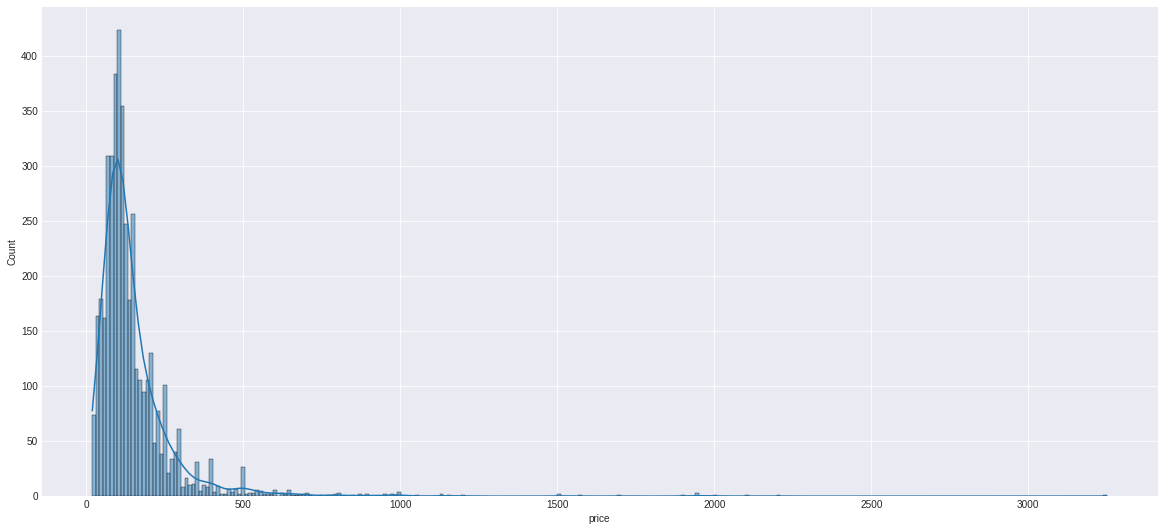

In [82]:
fig, ax = plt.subplots(figsize=(20,9));
sns.histplot(data=df, x='price', ax=ax, kde=True);

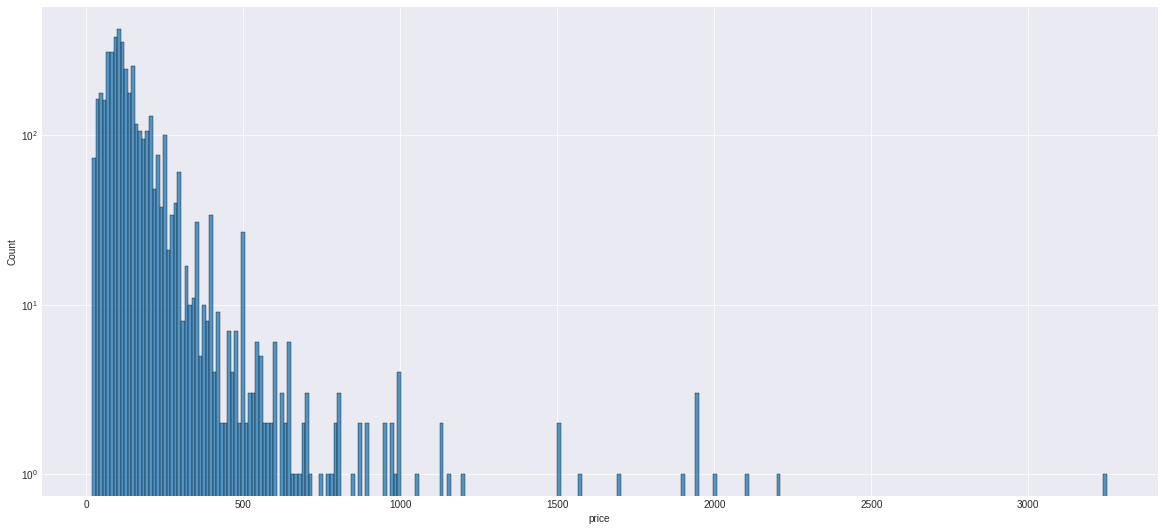

In [81]:
# Log scale plot of the above
fig, ax = plt.subplots(figsize=(20,9));
sns.histplot(data=df, x='price', ax=ax);
ax.set_yscale('log')

Let's take a look at the high end of the scale.

### Q3:

In [ ]:
#with plt.style.context('default'):
#    pd.plotting.scatter_matrix(df, alpha=0.3)

In [ ]:
#sns.pairplot(data=df)

In [ ]:
df.groupby(by='neighbourhood')['price'].median().sort_values().index

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
# Plotting by median price value
order = df.groupby(by='neighbourhood')['price'].median().sort_values().index
sns.stripplot(data=df, x='neighbourhood', y='price', order=order, ax=ax, s=3, alpha=.5, jitter=0.25, edgecolor='#333333', linewidth=.5);
sns.boxplot(data=df, x='neighbourhood', y='price', order=order, ax=ax);
plt.xticks(rotation=45, ha='right', size=15);
plt.yscale('log')
y_ticks = list(chain(range(50,500,50), range(500, 1000, 100), range(1000, 5000, 1000)))
plt.yticks(ticks=y_ticks, labels=y_ticks);


In [ ]:
df['room_type'].value_counts()

Consistently low ratings get [removed](https://www.airbnb.ca/help/article/2159/how-does-my-experiences-rating-or-reviews-affect-my-ability-to-host#:~:text=Guests%20like%20to%20know%20they,and%2For%20removed%20from%20Airbnb.) from AirBnB, probably explaining the lack of places with lots of reviews but reviewed at a low score.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,9))
sns.histplot(data=df, x='number_of_reviews', ax=axes[0])
sns.histplot(data=df, x='review_scores_rating', ax=axes[1])

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
sns.scatterplot(data=df, x='number_of_reviews', y='review_scores_rating', s=30, alpha=0.2, color='black', ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
sns.scatterplot(data=df, x='review_scores_rating', y='price', s=30, alpha=0.2, color='black', ax=ax);

In [ ]:
df['price'].corr(df['review_scores_rating'])

Perhaps hosts are setting price first, and customers based on overall...

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
sns.scatterplot(data=df, x='review_scores_value', y='price', s=30, alpha=0.2, color='black', ax=ax);

In [ ]:
df['price'].corr(df['review_scores_value'])

In [ ]:
# Host since histogram

In [ ]:
# Bed vs bathroom

In [ ]:
# Review framing

## Linear modelling

In [ ]:
## Predicting for price
# Drop columns that aren't useful
df_price = df.drop(labels=['id', 'latitude', 'longitude', 'host_id'], axis=1).copy()

In [ ]:
# Helper func to get timedeltas
def time_since(old_time, new_time):
    """
    Return a timedelta obj that is new_time - old_time (datetime objs).
    """
    return new_time - old_time

In [ ]:
# These datetime columns are dates in the past
df_price.columns[df_price.dtypes == 'datetime64[ns]']

In [ ]:
# Convert datetime columns 'host_since', 'first_review', and 'last_review' to days until when the data was scraped
DATE_SCRAPED = pd.to_datetime('2021-04-15', format='%Y-%m-%d')
col_apply_inplace(df_price, ['host_since', 'first_review', 'last_review'], time_since, new_time=DATE_SCRAPED)

In [ ]:
df_price.info()

In [ ]:
# These are the quantitative variables where NA's have to be filled.
df_price.columns[df_price.isna().sum()>0]

For reviews, the median or mean makes sense.

For first_review or last_review, and reviews_per_month, NA's basically mean there's no reviews, so 0 makes sense.



In [ ]:
df_price['host_since'].dt.days.plot.hist(bins=50)

In [ ]:
df_price['host_is_superhost'].value_counts().plot.bar()

In [ ]:
type(df_price['host_since'][0])

In [ ]:
df_price[df_price['host_since'].isna()]

In [ ]:
listings[listings['host_since'].isna()]

In [ ]:
df_price.head(1).loc[:,(df_price.dtypes == 'int64' )| (df_price.dtypes == 'float64')]

In [ ]:
# These columns are strings that will have to be converted to dummies
dummy_cols = df_price.columns[df_price.dtypes == 'object']
print(dummy_cols)

In [ ]:
df_price_dummied = pd.get_dummies(df_price, columns=dummy_cols, prefix=dummy_cols, drop_first=True)

In [ ]:
df_price_dummied.head(1)

In [ ]:
df_price_dummied.info()

In [ ]:
df_price_dummied_filled = df_price_dummied.fillna(df_price_dummied.median())

In [ ]:
df_price_dummied.shape

In [ ]:
# rename
df_pdf = df_price_dummied_filled.copy()

In [ ]:
df_pdf.info()

In [ ]:
df_pdf['host_since'].dt.days.hist(bins=50)

In [ ]:
# Change timedelta to days
cols_td = df_pdf.columns[df_pdf.dtypes == "timedelta64[ns]"]
df_pdf[cols_td] = df_pdf[cols_td].apply(lambda x: x.dt.days)

In [ ]:
X = df_pdf.loc[:,~(df_pdf.columns == 'price')]

In [ ]:
X.shape

In [ ]:
y = df['price']

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, test_size = 0.3)

In [ ]:
lm_model = LinearRegression(normalize=True)

In [ ]:
lm_model.fit(X_train, y_train)

In [ ]:
y_preds = lm_model.predict(X_test)

In [ ]:
r_score = r2_score(y_test, y_preds)

In [ ]:
print(r_score)

In [ ]:
lm_model.get_params()

In [ ]:
y_test

In [ ]:
y_test_reset = y_test.reset_index(drop=True)

In [ ]:
results = pd.concat([pd.Series(y_preds), y_test_reset, y_preds - y_test_reset, (y_preds - y_test_reset)/y_test_reset], axis=1)
print(results)

In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(y_test_reset, y_preds, s=4, alpha=0.3);


In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(y_test_reset, (y_preds - y_test_reset)/y_test_reset, s=4, alpha=0.3);

In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(y_test_reset, y_preds - y_test_reset, s=4, alpha=0.3);

In [ ]:
coefs = pd.concat([X.columns.to_series().reset_index(drop=True), pd.Series(lm_model.coef_)], axis=1)
coefs.columns = ['feature', 'coef']
print(coefs)

In [ ]:
coefs.sort_values(by='coef')

In [ ]:
for i, col in enumerate(X.columns):
    print(X.columns[i] + " " + str(np.round(lm_model.coef_[i], decimals=3)))

# Predicting rating


In [ ]:
df_pdf.columns

In [ ]:
df_review = df_pdf.drop(labels=['number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'reviews_per_month',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'], axis=1).copy()

In [ ]:
y2 = df_review['review_scores_rating']
X2 = df_review.drop(labels=['review_scores_rating'], axis=1)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=7, test_size=0.3)

In [ ]:
lm_model2 = LinearRegression(normalize=True)

In [ ]:
lm_model2.fit(X2_train, y2_train)

In [ ]:
y2_preds = lm_model2.predict(X2_test)

In [ ]:
r_score = r2_score(y2_test, y2_preds)
print(r_score)

In [ ]:
y2_test_reset = y2_test.reset_index(drop=True)
results2 = pd.concat([pd.Series(y2_preds), y2_test_reset, y2_preds - y2_test_reset, (y2_preds - y2_test_reset)/y2_test_reset], axis=1)
print(results2)

In [ ]:
plt.figure(figsize=(14,9))
plt.scatter(y2_test_reset, y2_preds,  s=4, alpha=0.3)
plt.xlim(0,120)
plt.ylim(0,120)

In [ ]:
plt.figure(figsize=(14,9))
plt.scatter(y2_test_reset, (y2_preds - y2_test_reset)/y2_test_reset, s=4, alpha=0.3);

In [ ]:
plt.figure(figsize=(14,9))
plt.scatter(y2_test_reset, (y2_preds - y2_test_reset), s=4, alpha=0.3);

In [ ]:
coefs2 = pd.concat([X2.columns.to_series().reset_index(drop=True), pd.Series(lm_model2.coef_)], axis=1)
coefs2.columns = ['feature', 'coef']
print(coefs2)

In [ ]:
coefs2.sort_values(by='coef')

check what happens when drop extremes for r2 scores

# Predicting binarily

In [ ]:
df_pdf['price'].describe()

In [ ]:
df_pdf_bi = df_pdf.copy()

In [ ]:
df_pdf_bi['premium'] = (df_pdf['price'] > 115).astype(int)

In [ ]:
df_pdf_bi.head()

In [ ]:
X3 = df_pdf_bi.drop(labels=['premium'], axis=1)
y3 = df_pdf_bi['premium']

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=7, test_size=0.3)
lm_model3 = LinearRegression(normalize=True)
lm_model3.fit(X3_train, y3_train)
y3_preds = lm_model3.predict(X3_test)
r_score3 = r2_score(y3_test, y3_preds)
print(r_score3)

In [ ]:
fpr, tpr, thresholds = roc_curve(y3_test, y3_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

In [ ]:
display.plot()
plt.show()

In [ ]:
thresholds

In [ ]:
spearmanr(y3_test, y3_preds)

In [ ]:
pearsonr(y3_test, y3_preds)

In [ ]:
plt.figure(figsize=(14,9))
sns.swarmplot(x=y3_test, y=y3_preds, s=7)

Capping predictions between 0 and 1?!??!

# Model after withdrawing some params

e.g. remove hotel because it's only 4

# Conclusions and Discussion

model across time and cities

## Resources